# Prediction price range of cars

## Approach

- Data cleaning proccesing
- EDA
   
- Build Model
  - supervised learning models for classification
- Model Evaluation

## Setup

In [2]:
# Load required packages
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from shapash.explainer.smart_explainer import SmartExplainer


In [3]:
# quality-of-life
pd.options.mode.use_inf_as_na = True
pd.set_option("display.max_columns", 50)
pd.set_option('display.max_rows', 50)
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.style.use("ggplot")

## Extract

In [4]:
df = pd.read_csv('car_data.csv')
df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Make               11914 non-null  object 
 1   Model              11914 non-null  object 
 2   Year               11914 non-null  int64  
 3   Engine Fuel Type   11911 non-null  object 
 4   Engine HP          11845 non-null  float64
 5   Engine Cylinders   11884 non-null  float64
 6   Transmission Type  11914 non-null  object 
 7   Driven_Wheels      11914 non-null  object 
 8   Number of Doors    11908 non-null  float64
 9   Market Category    8172 non-null   object 
 10  Vehicle Size       11914 non-null  object 
 11  Vehicle Style      11914 non-null  object 
 12  highway MPG        11914 non-null  int64  
 13  city mpg           11914 non-null  int64  
 14  Popularity         11914 non-null  int64  
 15  MSRP               11914 non-null  int64  
dtypes: float64(3), int64(5

In [6]:
df.describe()

,Year,Engine HP,Engine Cylinders,Number of Doors,highway MPG,city mpg,Popularity,MSRP
count,11914.000000,11845.00000,11884.000000,11908.000000,11914.000000,11914.000000,11914.000000,1.191400e+04
mean,2010.384338,249.38607,5.628829,3.436093,26.637485,19.733255,1554.911197,4.059474e+04
std,7.579740,109.19187,1.780559,0.881315,8.863001,8.987798,1441.855347,6.010910e+04
min,1990.000000,55.00000,0.000000,2.000000,12.000000,7.000000,2.000000,2.000000e+03
25%,2007.000000,170.00000,4.000000,2.000000,22.000000,16.000000,549.000000,2.100000e+04
50%,2015.000000,227.00000,6.000000,4.000000,26.000000,18.000000,1385.000000,2.999500e+04
75%,2016.000000,300.00000,6.000000,4.000000,30.000000,22.000000,2009.000000,4.223125e+04
max,2017.000000,1001.00000,16.000000,4.000000,354.000000,137.000000,5657.000000,2.065902e+06


there might be some outliers in MPG columns as max value is much higher than 75% value


In [7]:
df.describe(include='object')

,Make,Model,Engine Fuel Type,Transmission Type,Driven_Wheels,Market Category,Vehicle Size,Vehicle Style
count,11914,11914,11911,11914,11914,8172,11914,11914
unique,48,915,10,5,4,71,3,16
top,Chevrolet,Silverado 1500,regular unleaded,AUTOMATIC,front wheel drive,Crossover,Compact,Sedan
freq,1123,156,7172,8266,4787,1110,4764,3048


In [8]:
cat_cols = ['Make','Engine Fuel Type','Transmission Type','Driven_Wheels','Market Category','Vehicle Size','Vehicle Style']
(pd.DataFrame(
    df[cat_cols]
    .melt(var_name='column', value_name='value')
    .value_counts())
    .rename(columns={0: 'counts'})
    .sort_values(by=['column', 'counts']))

counts
column           value                    
Driven_Wheels    four wheel drive     1403
                 all wheel drive      2353
                 rear wheel drive     3371
                 front wheel drive    4787
Engine Fuel Type natural gas             2
...                                    ...
Vehicle Style    4dr Hatchback         702
                 Convertible           793
                 Coupe                1211
                 4dr SUV              2488
                 Sedan                3048

[157 rows x 1 columns]

## Clean and transform data

<AxesSubplot: >

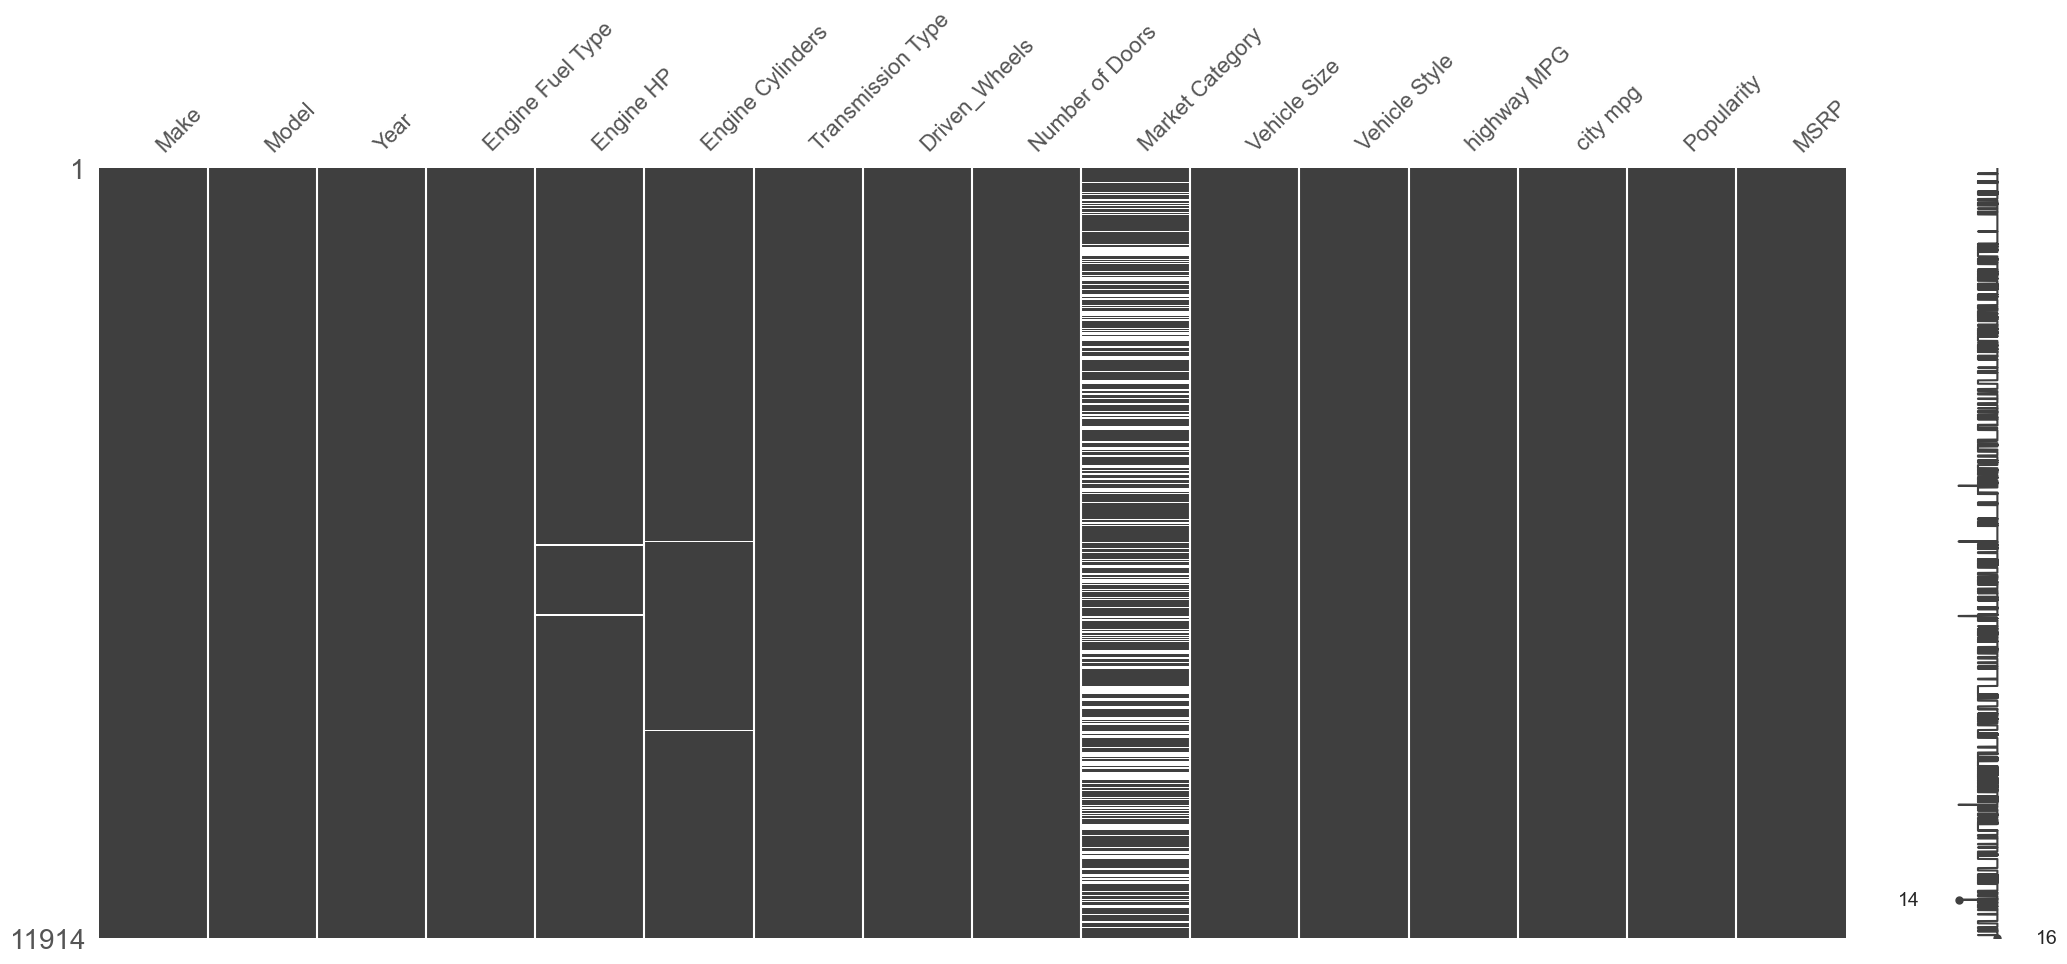

In [9]:
# visualise missing data
msno.matrix(df)

In [10]:
# study Market Categorie NA
df['Market Category'].isna().sum()

3742

In [11]:
# remove NAs 
df = df.dropna()

A more acurate method is to predict values of Market category, other records don't have many missing values

In [12]:
# spilit Market Category column
df2 = df['Market Category'].str.get_dummies(',')
df = df.join(df2)
df = df.drop('Market Category', axis=1)
df.head(3)

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP,Crossover,Diesel,Exotic,Factory Tuner,Flex Fuel,Hatchback,High-Performance,Hybrid,Luxury,Performance
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,Compact,Coupe,26,19,3916,46135,0,0,0,1,0,0,1,0,1,0
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,Compact,Convertible,28,19,3916,40650,0,0,0,0,0,0,0,0,1,1
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,Compact,Coupe,28,20,3916,36350,0,0,0,0,0,0,1,0,1,0


<AxesSubplot: >

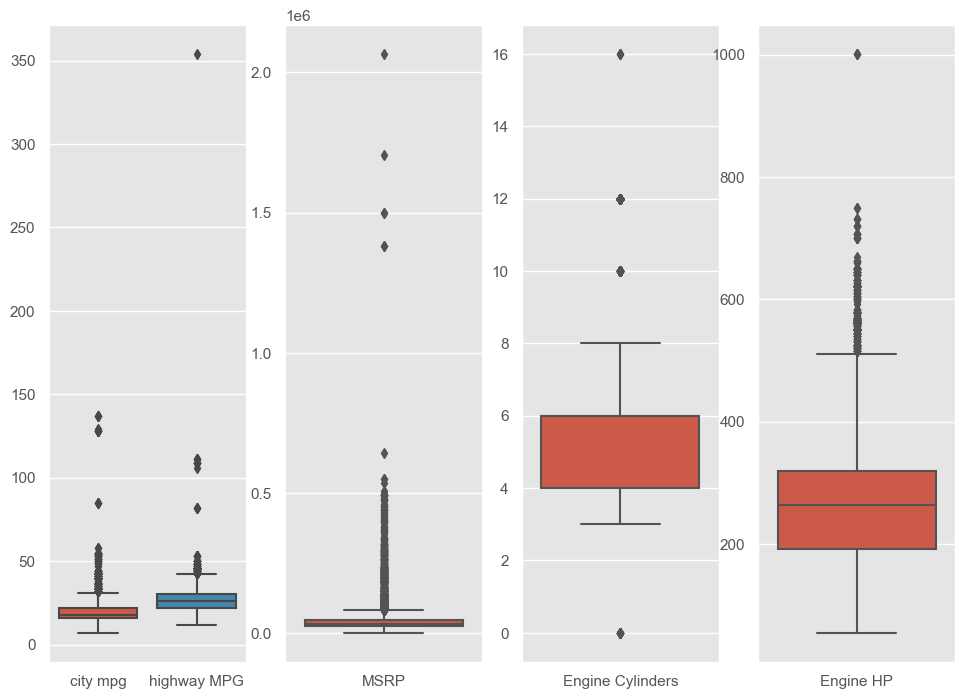

In [13]:
#investigating potential outliers
fig, ax =plt.subplots(1,4)
sns.boxplot(data=df[["city mpg", "highway MPG"]],ax=ax[0])
sns.boxplot(data=df[["MSRP"]],ax=ax[1])
sns.boxplot(data=df[["Engine Cylinders"]],ax=ax[2])
sns.boxplot(data=df[["Engine HP"]],ax=ax[3])



In [14]:
#remove outliers
cat_cols =['city mpg','highway MPG','Engine Cylinders','Engine HP','MSRP']
for x in cat_cols:
    p_25, p_75 = np.percentile(df[x], [25, 75])
    iqr = p_75 - p_25
    upper_bound = p_75 + (1.5 * iqr)
    lower_bound = p_25 - (1.5 * iqr)
    df = df[df[x] < upper_bound]
    df = df[df[x] > lower_bound]

In [15]:
# The hashing is used to reduce memory consumption by the features.
cols = df.select_dtypes(include="object").columns
for i in cols:
    df[i] = df[i].map( lambda  x: hash(x))

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6719 entries, 0 to 11913
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Make               6719 non-null   int64  
 1   Model              6719 non-null   int64  
 2   Year               6719 non-null   int64  
 3   Engine Fuel Type   6719 non-null   int64  
 4   Engine HP          6719 non-null   float64
 5   Engine Cylinders   6719 non-null   float64
 6   Transmission Type  6719 non-null   int64  
 7   Driven_Wheels      6719 non-null   int64  
 8   Number of Doors    6719 non-null   float64
 9   Vehicle Size       6719 non-null   int64  
 10  Vehicle Style      6719 non-null   int64  
 11  highway MPG        6719 non-null   int64  
 12  city mpg           6719 non-null   int64  
 13  Popularity         6719 non-null   int64  
 14  MSRP               6719 non-null   int64  
 15  Crossover          6719 non-null   int64  
 16  Diesel             6719

## Exploratory data analysis

<AxesSubplot: xlabel='MSRP', ylabel='Count'>

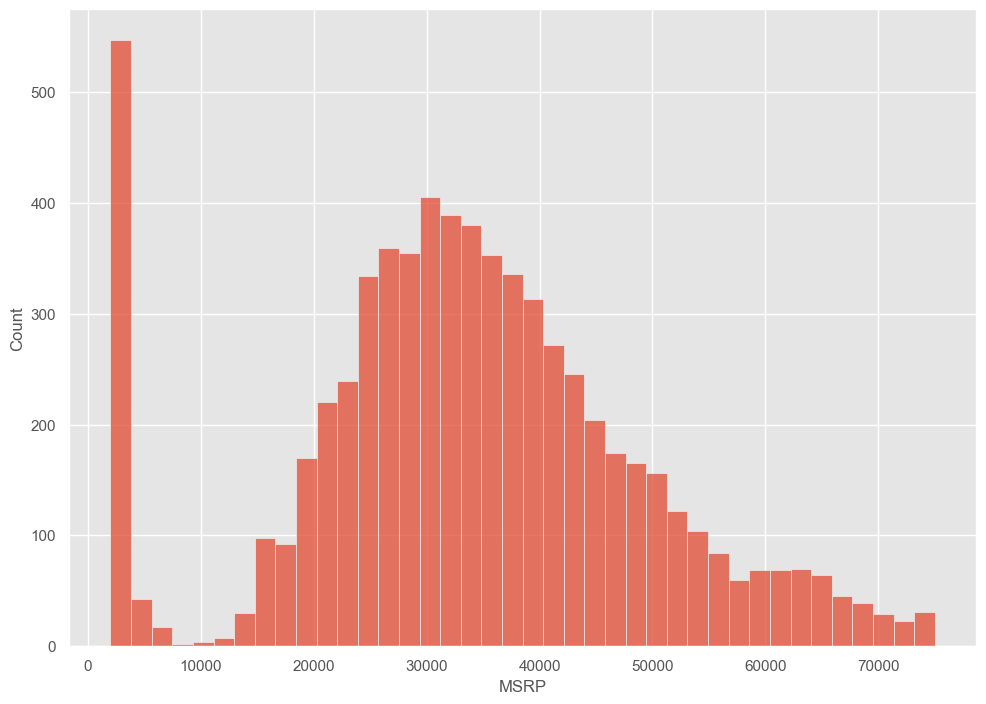

In [17]:
#exploring Target variable
sns.histplot(df["MSRP"])


In [18]:
df['MSRP'].describe()

count     6719.000000
mean     33569.873195
std      15496.613506
min       2000.000000
25%      25047.000000
50%      33260.000000
75%      42685.000000
max      75010.000000
Name: MSRP, dtype: float64

Although there are many data on the left side of plot, but mean and median are very close, so we can conclude the data is normally distributed

In [19]:
df.Year.value_counts()/len(df)

2016    0.204644
2015    0.197351
2017    0.157464
2014    0.052091
2013    0.038399
2009    0.037803
2012    0.036910
2007    0.032445
2010    0.030362
2011    0.029618
2008    0.026343
2006    0.015181
1993    0.013097
1992    0.012502
2005    0.011460
2004    0.010865
2003    0.009972
1994    0.008930
1997    0.008781
2002    0.008781
1991    0.008632
2000    0.008335
1996    0.008186
1995    0.007739
2001    0.007590
1999    0.006251
1990    0.005507
1998    0.004763
Name: Year, dtype: float64

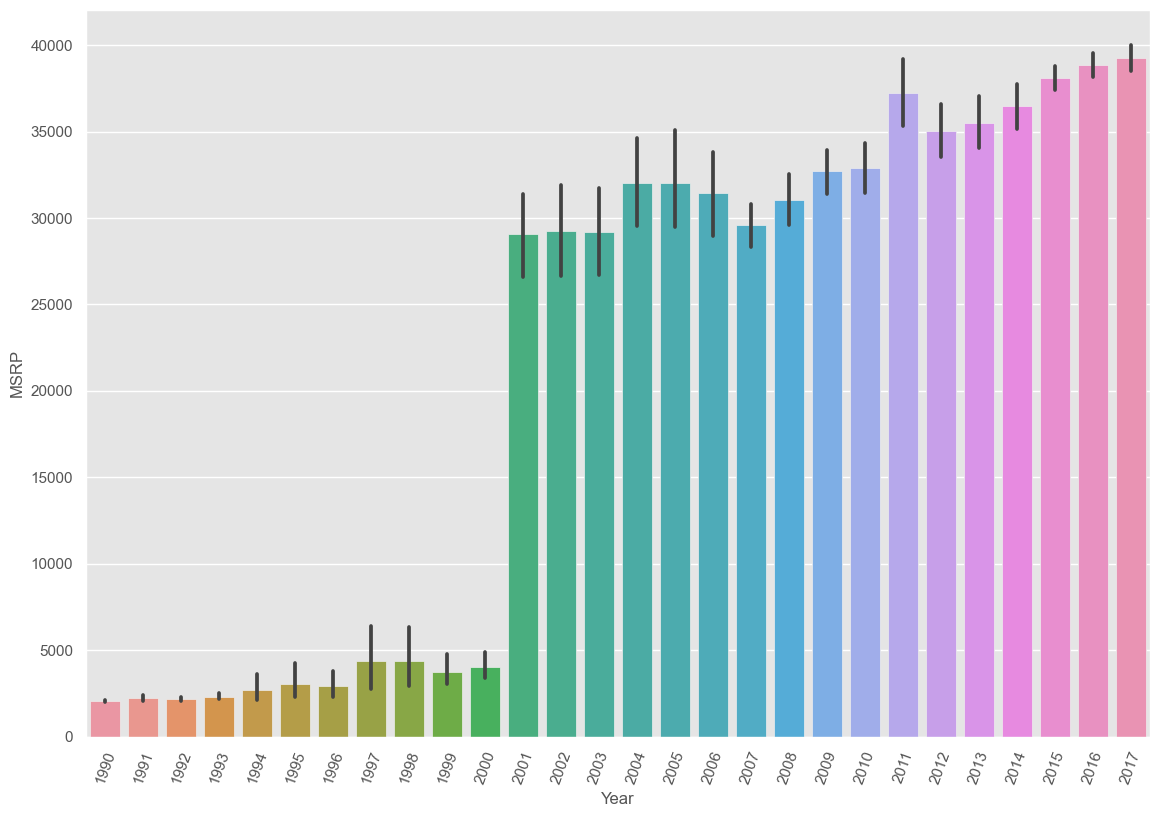

In [20]:
sns.barplot(data=df, x="Year", y="MSRP")
plt.xticks(rotation=70)
plt.tight_layout()

In [21]:
df['Number of Doors'].value_counts()/len(df) 

4.0    0.730912
2.0    0.242596
3.0    0.026492
Name: Number of Doors, dtype: float64

In [22]:
df['Engine Cylinders'].value_counts()/len(df)

4.0    0.414794
6.0    0.408692
8.0    0.149725
5.0    0.025301
3.0    0.001488
Name: Engine Cylinders, dtype: float64

<AxesSubplot: xlabel='Engine Cylinders', ylabel='MSRP'>

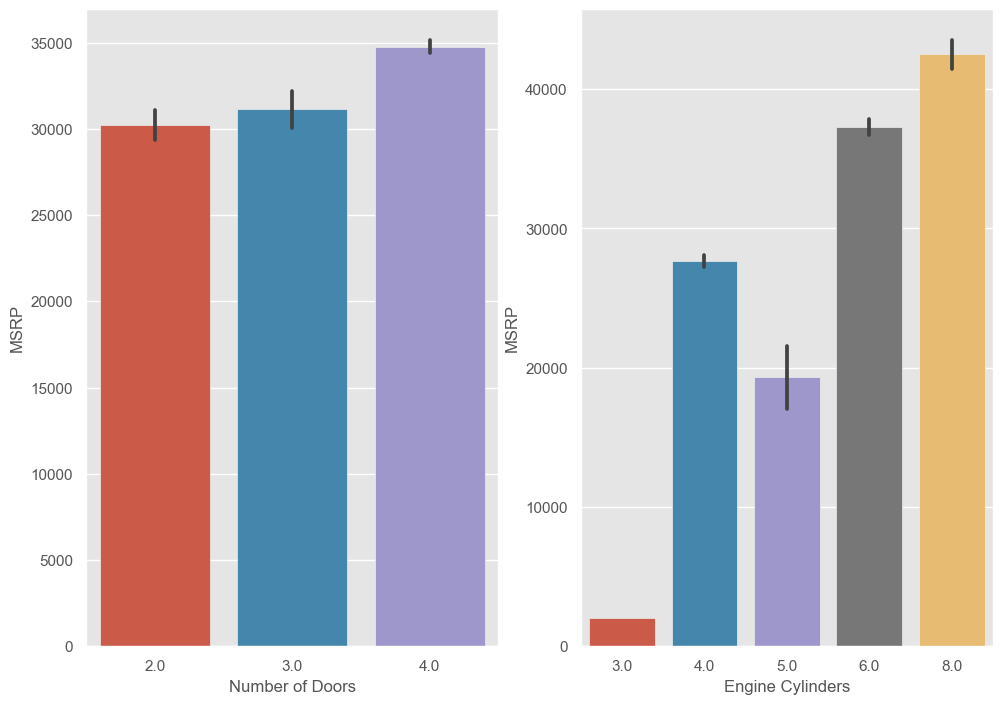

In [23]:
fig, ax =plt.subplots(1,2)
sns.barplot(data=df, x="Number of Doors", y="MSRP", ax=ax[0])
sns.barplot(data=df, x="Engine Cylinders", y="MSRP",  ax=ax[1])

<AxesSubplot: xlabel='city mpg', ylabel='Density'>

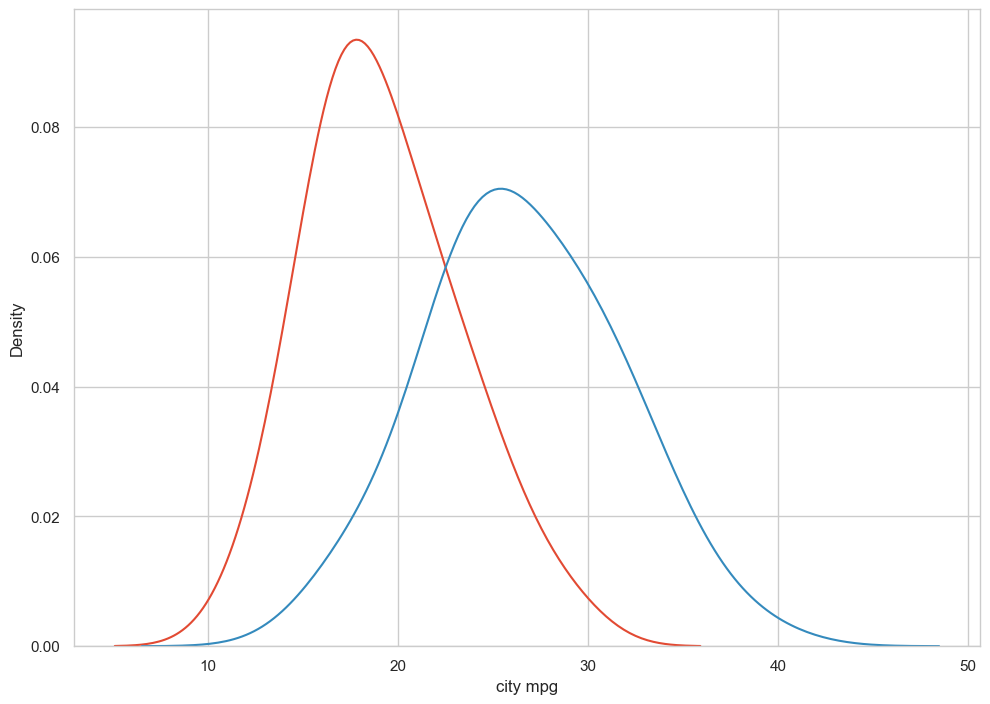

In [24]:
sns.set_style('whitegrid')
sns.kdeplot(df['city mpg'], bw_method=0.5)
sns.kdeplot(df['highway MPG'], bw_method=0.5)

they look too corolated, may be we can merge them in to one (sum of both)

## Model Training & Evaluation

Decision tree-based algorithms are currently considered to be the best algorithms for problems involving small-to-medium data structures.

In [25]:
# set target variable and features
X = df.drop(["MSRP"], axis=1)
y = df["MSRP"]

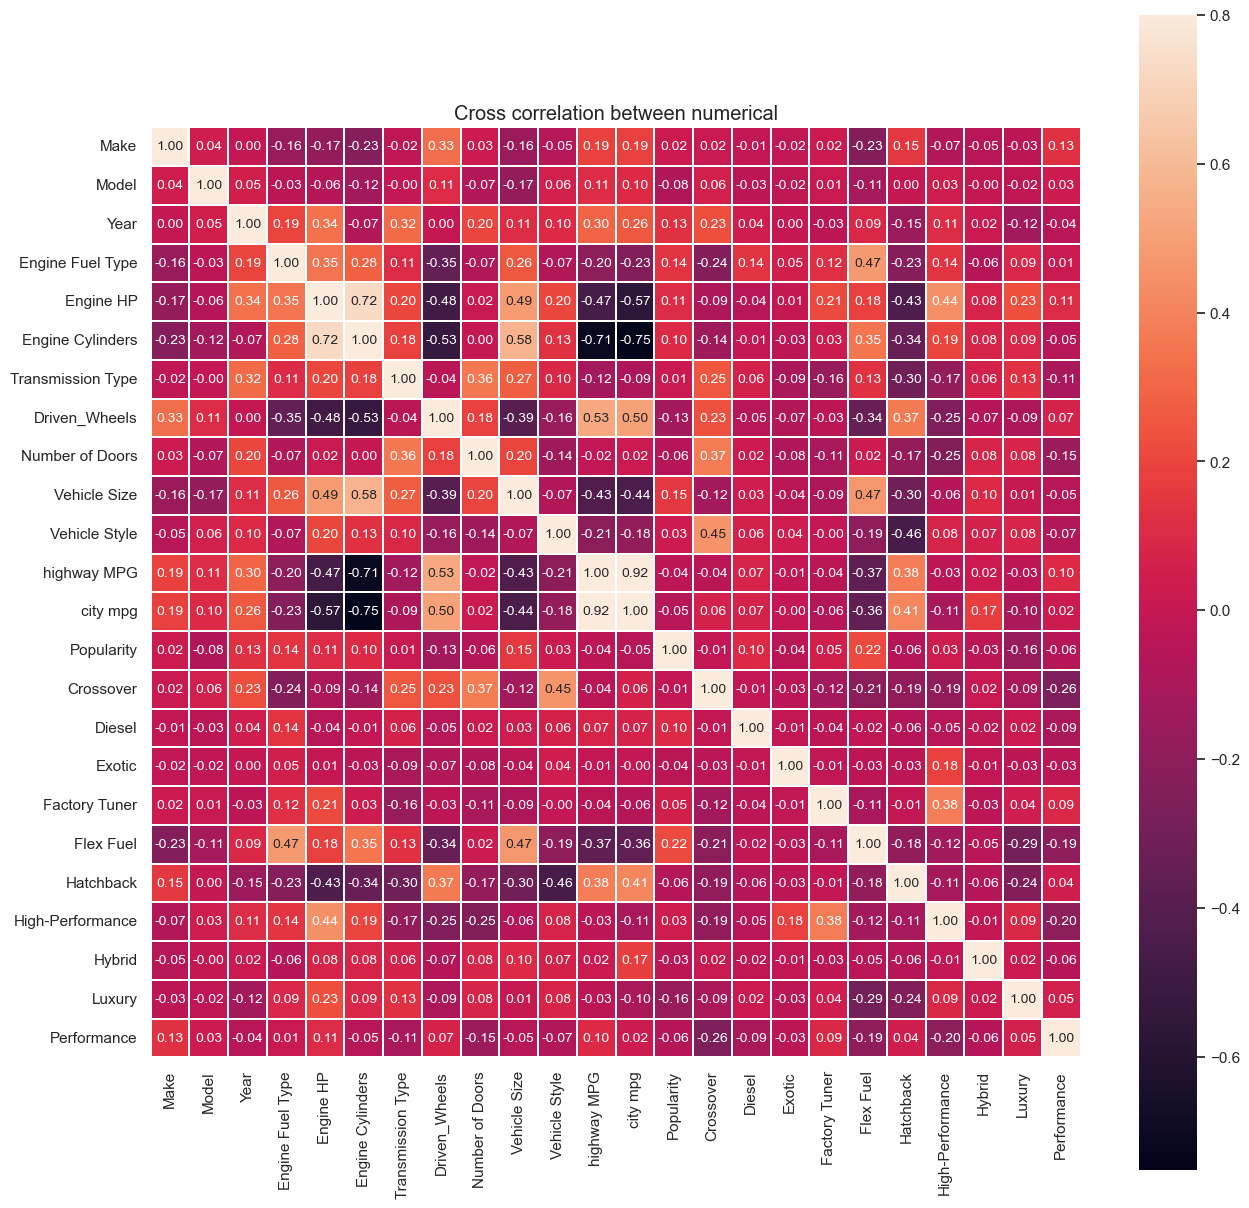

In [26]:
plt.figure(figsize=(15, 15))
ax = sns.heatmap(X.corr(), vmax=.8, square=True, fmt='.2f', annot=True, linecolor='white', linewidths=0.01)
plt.title('Cross correlation between numerical')
plt.show()

# 1) Random Forest

In [27]:
# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# model
Regressor = RandomForestRegressor(n_estimators = 300, max_features = 'sqrt', max_depth = 5, random_state = 18)
forest = Regressor.fit(X_train, y_train)
prediction = forest.predict(X_test)

In [28]:
#print result
print(f"---------- Metrics --------------")
print(f"| R2 score:  {(r2_score(y_test,prediction)):06.2%}             |")
print(f"| MSE:       {mean_squared_error(y_test, prediction)} |")
print(f"| RMSE:      {mean_squared_error(y_test, prediction)**.5} |")
print(f"---------------------------------")

---------- Metrics --------------
| R2 score:  80.41%             |
| MSE:       48683368.59221463 |
| RMSE:      6977.34681610529 |
---------------------------------


### 2) LightGBM

In [29]:
# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# model
Regressor = LGBMRegressor()
ltgbm = Regressor.fit(X_train, y_train)
prediction = ltgbm.predict(X_test)

In [30]:
#print result
print(f"---------- Metrics --------------")
print(f"| R2 score:  {(r2_score(y_test,prediction)):06.2%}             |")
print(f"| MSE:       {mean_squared_error(y_test, prediction)} |")
print(f"| RMSE:      {mean_squared_error(y_test, prediction)**.5} |")
print(f"--------------------------------")

---------- Metrics --------------
| R2 score:  95.24%             |
| MSE:       11367798.128010832 |
| RMSE:      3371.6165452214213 |
--------------------------------


### 3) XGBoost

In [31]:
# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# model
Regressor = LGBMRegressor()
xgbt = Regressor.fit(X_train, y_train)
prediction = xgbt.predict(X_test)

In [32]:
#print result
print(f"---------- Metrics --------------")
print(f"| R2 score:  {(r2_score(y_test,prediction)):06.2%}             |")
print(f"| MSE:       {mean_squared_error(y_test, prediction)} |")
print(f"| RMSE:      {mean_squared_error(y_test, prediction)**.5} |")
print(f"--------------------------------")

---------- Metrics --------------
| R2 score:  95.30%             |
| MSE:       10984100.066364786 |
| RMSE:      3314.2269183573994 |
--------------------------------


LightGBM explained 95% of data, wich is the highest score among our models and has the least RMSE (3330) so we go on with this model for model Evaluation

## Feature Evaluation

In [33]:
# set up tree explainer
xpl = SmartExplainer(model=xgbt)
xpl.compile(x=X_test)

In [36]:
# feature importance
# prioritise feature engineering and prune low-contributing features
xpl.plot.features_importance()

Engine HP, production year , and Luxury have the most infuence on model
crossover Hybrid and High-performance have the least impact on model

In [35]:
# top interactions
# examine assumptions about interactions between each feature
xpl.plot.top_interactions_plot(nb_top_interactions=10)

## Potential Improvements
1. Feature Engineering
    - Derive additional features (like a unique MPG)
    - Splitting data in a better way (based on year rather than randomly)
2. Model Design
    - Using Deep learning models
    - Using k-fold cross validation to to avoid overfitting

## Putting model in to production
The produced model explain the data effectively and reliable for predicting the prices of cars produced in 2017 and before.
